[-1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01 -2.22044605e-16  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01]


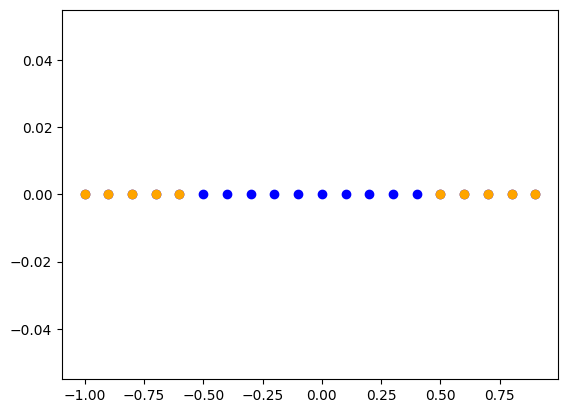

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Generamos nuestro dataset

data = np.arange(-1,1,0.1)
print(data)
labels = np.ones(len(data))
labels[len(data)//4:-len(data)//4] *= -1

plt.scatter(data, np.zeros(len(data)), color = "blue")
plt.scatter(data[:len(data)//4], np.zeros(len(data)//4), color = "orange")
plt.scatter(data[-len(data)//4:], np.zeros(len(data)//4), color = "orange")

In [3]:

# Entrenamiento estandar de una red neuronal cuántica

def feature_map(x):
    qml.Hadamard(wires = 0)
    qml.RZ(x , wires = 0)

def variational_block(params):
    qml.U3(params[0], params[1], params[2], wires = 0)

dev = qml.device("default.qubit", wires = 1)

@qml.qnode(dev)
def circuit(x, params):

    feature_map(x)
    variational_block(params)

    return qml.expval(qml.PauliZ(0))


def error(data, labels, params):

    err = 0
    for i in range(len(data)):
        d = circuit(data[i], params)
        err -= labels[i] * d

    return err / len(data)

def accuracy(data, labels, params):

    n = 0
    for i in range(len(data)):
        if labels[i] == np.sign(circuit(data[i], params)):
            n += 1

    return n / len(data)


def train(data, labels, error_function, params, stepsize = 0.1, epochs = 100, plot = True):
    opt = qml.AdagradOptimizer(stepsize = stepsize)

    costs = []
    for epoch in range(epochs):
        params, cost = opt.step_and_cost(lambda params: error_function(data, labels, params), params)
        costs.append(cost)

    if plot:
        plt.plot(costs)

    return params


/usr/local/lib/python3.10/dist-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


0.5


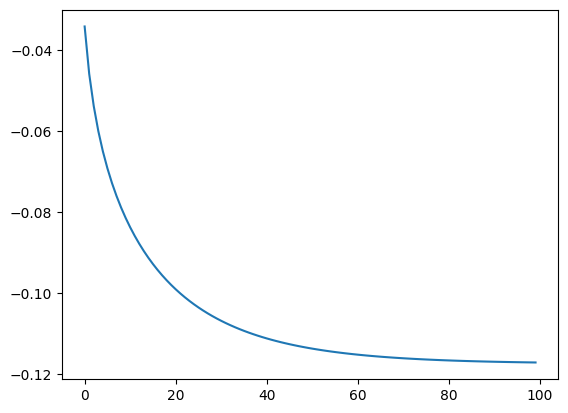

In [4]:
initial_params = np.random.rand(3, requires_grad = True)
#print(initial_params)
params = train(data, labels, error, initial_params)
print(accuracy(data, labels, params))

Recordemos que la formula del error para entrenar nuestro feature map F es:


$$\text{Error} = -\sum_i\sum_j y_iy_j\langle F(x_i)^{\dagger}F(x_j)\rangle$$

Definiremos por tanto un feature map variacional y minimizaremos dicho error.

In [5]:
def feature_map(x, feature_param):
    qml.Hadamard(wires = 0)
    qml.RZ(x * feature_param, wires = 0)

def feature_error(data, labels, feature_param):

    dev = qml.device("default.qubit", wires = 1)
    @qml.qnode(dev)
    def circuit(x1, x2):
        feature_map(x1, feature_param)
        qml.adjoint(feature_map)(x2, feature_param)
        return qml.probs(wires = 0)

    err = 0
    for i in range(len(data)):
        for j in range(i, len(data)):
            d = circuit(data[i], data[j])
            err -= labels[i] * labels[j] * d[0][0]
    return err


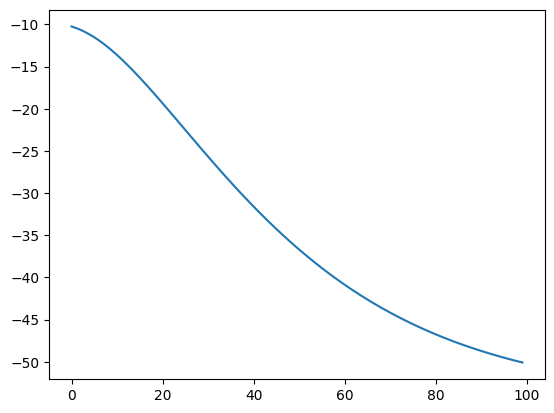

In [6]:
initial_param = np.random.rand(1, requires_grad = True)
param = train(data, labels, feature_error, initial_param)
#param



In [7]:
def feature_map(x):
    qml.Hadamard(wires = 0)
    qml.RZ(x*3.1416 , wires = 0)

def variational_block(params):
    qml.U3(params[0], params[1], params[2], wires = 0)

dev = qml.device("default.qubit", wires = 1)

@qml.qnode(dev)
def circuit(x, params):

    feature_map(x)
    variational_block(params)

    return qml.expval(qml.PauliZ(0))


def error(data, labels, params):

    err = 0
    for i in range(len(data)):
        d = circuit(data[i], params)
        err -= labels[i] * d

    return err / len(data)

def accuracy(data, labels, params):

    n = 0
    for i in range(len(data)):
        if labels[i] == np.sign(circuit(data[i], params)):
            n += 1

    return n / len(data)


def train(data, labels, error_function, params, stepsize = 0.1, epochs = 100, plot = True):
    opt = qml.AdagradOptimizer(stepsize = stepsize)

    costs = []
    for epoch in range(epochs):
        params, cost = opt.step_and_cost(lambda params: error_function(data, labels, params), params)
        costs.append(cost)

    if plot:
        plt.plot(costs)

    return params

1.0


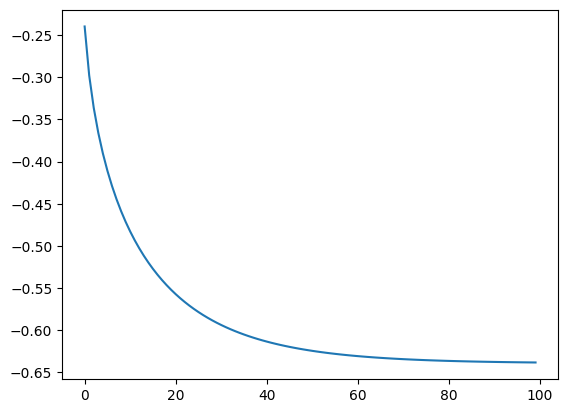

In [8]:
initial_params = np.random.rand(3, requires_grad = True)
#print(initial_params)
params = train(data, labels, error, initial_params)
print(accuracy(data, labels, params))